In [80]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# SK-learn libraries for data processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data using pandas.
train_data = pd.read_csv('data/train_users_2.csv')
test_data = pd.read_csv('data/test_users.csv')
print "Train data shape: {0}".format(train_data.shape)
print "--------------Train Data----------------------"
print train_data.info()
print "----------------------------------------------"

print "\n"
print "Test data shape: {0}".format(test_data.shape)
print "---------------Test Data----------------------"
print test_data.info()
print "----------------------------------------------"

In [39]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add age to features.
    # Set NA values to -1.
    data["age"] = data["age"].fillna(-1)
    # Add age data to training data.
    features_data = np.column_stack((features_data, np.array(data["age"])))
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(train_data)
test_data_x = ExtractFeatures(test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


### Exploring the data

#### Analysis of class distribution

Check training data to see how classes are distributed. It is obvious the training data is heavily imbalanced. 

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64


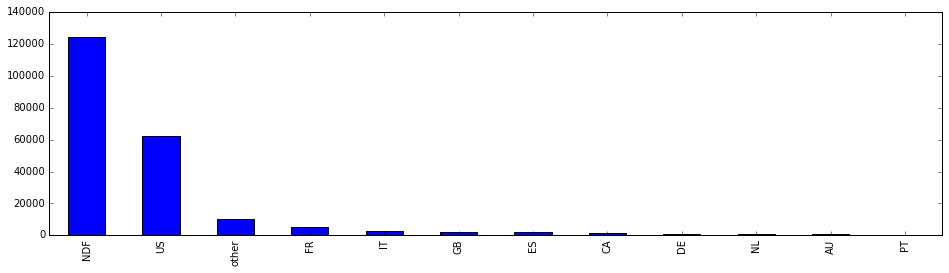

In [130]:
plt.figure(figsize=(16,4))
country_dist = train_data["country_destination"].value_counts()
plt.subplot(1,1,1)
country_dist.plot.bar()

print country_dist*1.0 / sum(country_dist)

#### Analysis of age data
We'll start with the assumption that valid age ranges should be between 18-100 since the minimum age according to the Terms of Service is 18. Any values outside of this range should be cleaned into valid values or set to 0
as invalid.

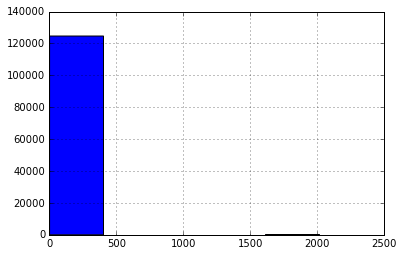

In [41]:
# Get all age values that are greater than zero.
GTE_zero_age = train_data[train_data.age >= 0].age
# Plot a histogram of these values.
GTE_zero_age.hist(bins=5)

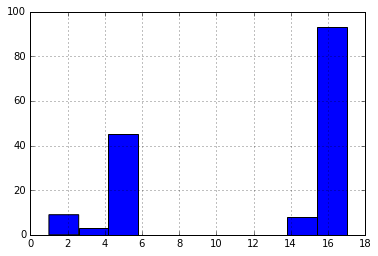

In [42]:
# Get all age values that are between 0 and 18.
under_18 = GTE_zero_age[GTE_zero_age < 18]
under_18.hist()
# All these values should be treated as invalid values.

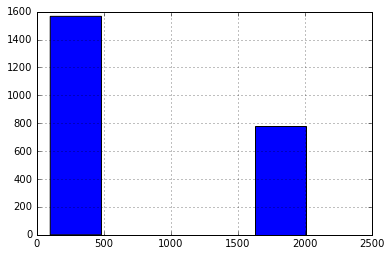

In [43]:
# From this, we can see that there are many large values.
# Assuming anything above 100 is not a valid, let's plot the
# histogram of those values.
GT_150 = train_data[train_data.age > 100].age
GT_150.hist(bins=5)
# We can't make much sense out of values between 100-1915 so
# those should be treated as invalid values as well.

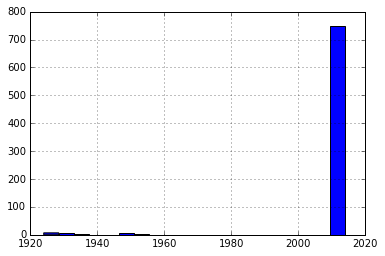

In [44]:
# Let's look more closely at those values greater than 1915.
GT_1915 = train_data[train_data.age > 1915].age
GT_1915.hist(bins=20)
# We have some values between 1915 and 1997 which we can
# assume could be birth years.
# The large number of values > 1997 are likely the current
# year the user registered.

In [45]:
# Helper function to clean up the age data based off
# this analysis in both the training and test data.
def CleanAgeData(df):
    age_data = df.age
    # Set missing values to -1.
    age_data = age_data.fillna(-1)
    # Set invalid values to 0.
    # Values between 0-18 are considered invalid.
    age_data[age_data.isin(range(0,18))] = 0
    # Values between 100-1915 are considered invalid.
    age_data[age_data.isin(range(101,1915))] = 0
    # Values >2010 are considered invalid.
    age_data[age_data > 1997] = 0
    # Compute age for values between 1915-1997.
    age_data[age_data.isin(range(1915,1998))] = 2015 - age_data[age_data.isin(range(1915,1998))]
    return age_data

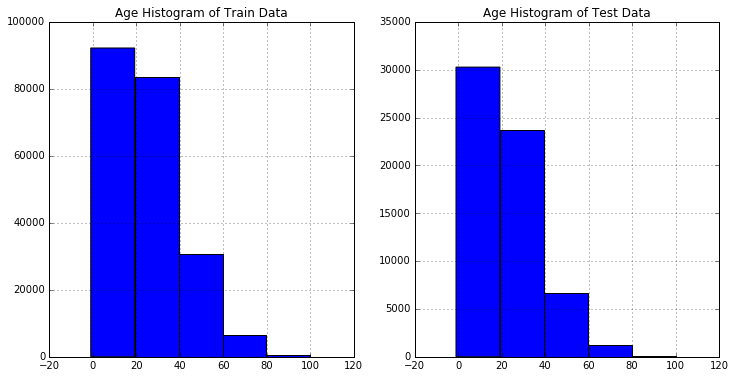

In [46]:
# Clean up training and test age data and plot cleaned data.
plt.figure(figsize=(12, 6))
train_age_data = CleanAgeData(train_data)
plt.subplot(1, 2, 1)
train_age_data.hist(bins=5)
plt.title("Age Histogram of Train Data")

test_age_data = CleanAgeData(test_data)
plt.subplot(1, 2, 2)
test_age_data.hist(bins=5)
plt.title("Age Histogram of Test Data")

#### Analysis of Date Data

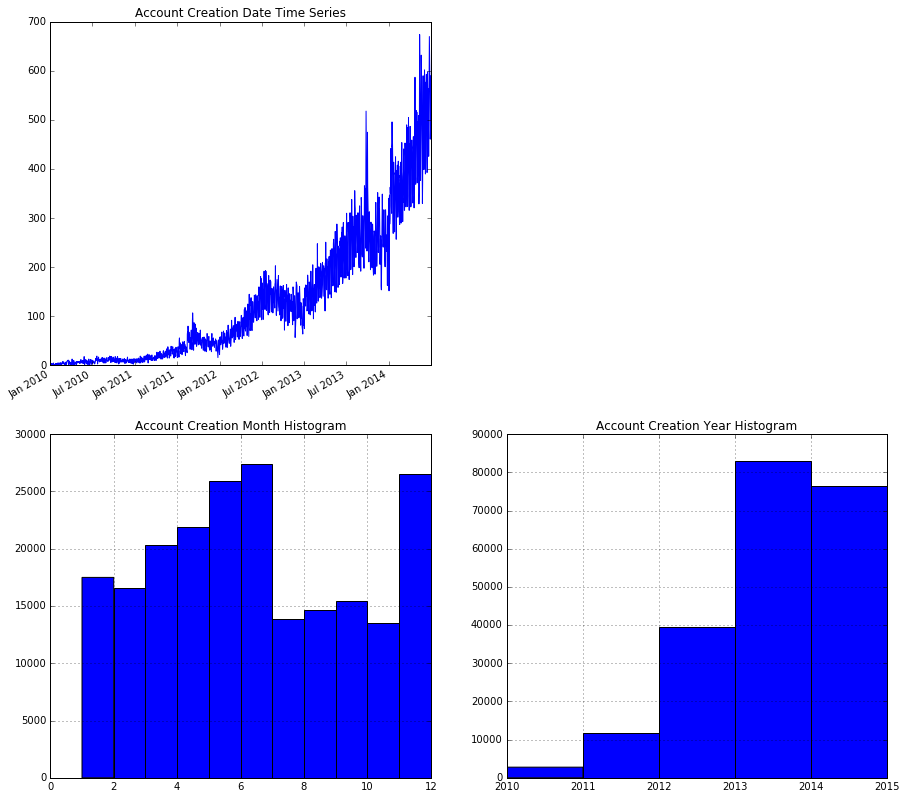

In [47]:
# Plot account created time series data.
plt.figure(figsize=(15, 15))
account_created_data = pd.to_datetime(train_data.date_account_created).value_counts()
plt.subplot(2, 2, 1)
account_created_data.plot()
plt.title("Account Creation Date Time Series")

# Plot account created month data.
account_created_month = pd.to_datetime(train_data.date_account_created).dt.month
plt.subplot(2, 2, 3)
account_created_month.hist(bins=range(1,13))
plt.title("Account Creation Month Histogram")

# Plot account created year data.
account_created_year = pd.to_datetime(train_data.date_account_created).dt.year
ax = plt.subplot(2, 2, 4)
account_created_year.hist(bins=[2010,2011,2012,2013,2014,2015])
ax.ticklabel_format(useOffset=False)
plt.title("Account Creation Year Histogram")

### Preparing Data

In [48]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add cleaned version of age data to features.
    age_data = CleanAgeData(data)
    # Add age data to training data.
    features_data = np.column_stack((features_data, np.array(age_data)))
    
    # Add account creation data (month and year).
    # These are currently commented out because they actually make the model performance worse.
    # Leaving them in since they might be useful for predicting NDF or booking.
#     account_creation_month = pd.to_datetime(data.date_account_created).dt.month
#     features_data = np.column_stack((features_data, np.array(account_creation_month)))
#     account_created_year = pd.to_datetime(data.date_account_created).dt.year
#     features_data = np.column_stack((features_data, np.array(account_created_year)))
    
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(train_data)
test_data_x = ExtractFeatures(test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451, 6)
Test data shape: (62096, 6)
Train labels shape: (213451,)


In [121]:
# Split train data into training and dev sets.
train_data_size = (len(train_data_x))/5*4
train_x, train_y = train_data_x[:train_data_size], train_data_y[:train_data_size]
dev_x, dev_y= train_data_x[train_data_size:], train_data_y[train_data_size:]

# save dev id to be used in score calculation
dev_id = np.array(train_data["id"][train_data_size:])
dev_dict = dict(zip(dev_id, dev_y))

print train_x.shape, train_y.shape
print dev_x.shape, dev_y.shape, dev_id.shape

#******************************************
# Try SMOTE here
#******************************************
print "\nTraining data after SMOTE"

country = 'FR'
train_x_c = train_x[train_y == country]

#SMOTE(minority data, new data size, NN steps)
#To double minority data example size, set N=1
#NN default = 5 neighbours
N = 4
train_x_c2 =  SMOTE(train_x_c,N*100,5)

#Append new data to train_x
train_x = np.vstack((train_x, train_x_c2))
#Append label to train_y
new_label = []
for i in range(N * len(train_x_c)):
    new_label.append(country)
train_y = np.concatenate((train_y, np.array(new_label)))

print train_x.shape, train_y.shape

#****** End of SMOTE test block **************

(170760, 6) (170760,)
(42691, 6) (42691,) (42691,)

Training data after SMOTE
(187460, 6) (187460,)


In [50]:
# Calculate DCG score based on Kaggle evaluation doc
def FinalScore(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            #scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    #scores.append((cur_id, dcg))
    
    return score/num_pred
    #return scores

In [51]:
# Build on top of DCG score function, output more prediction data
def Dump(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    scores.append((cur_id, dcg))
    
    #Output more info for error analysis
    dev_scores = dict(scores)
    dump = []
    temp_list = []
    for i in range(len(dev_x)):        
        temp_list = [dev_id[i], dev_y[i], dev_scores[dev_id[i]]]        
        dump.append(dev_x[i].tolist() + temp_list) 

    output = pd.DataFrame(dump, columns=["gender", "signup_method", "language", "first_device_type", 
                                         "first_browser", "age", "id", "country","score"])
    output.to_csv("dev_x_score.csv", index=False)
    
    buckets = [1.0, 0.6309, 0.5, 0.4307, 0.3869, 0.0]    
    plt.figure(figsize=(15, 15))
    
    for i in range(len(buckets)):    
        pred_count = output[abs(output.score - buckets[i]) < 0.001].country.value_counts()
        plt.subplot(2, 3, i+1)
        pred_count.plot.bar()

        if(i<5):
            plt.title("Correct prediction on attempt " + str(i+1))
            print "\nCorrect prediction dist on attempt %d"%(i+1)
        else:
            plt.title("Incorrect prediction dist")
            print "\nIncorrect prediction dist"
            
        print pred_count
    
    print "\nScore: %7.5f"%(score/num_pred)
    
    return 

In [52]:
# Helper function to return top 5 prediction result per example
# given a trained model.
def Predict_Top5(m):
    prob_est = m.predict_proba(dev_x)
    predictions = []
    
    for i, example in enumerate(prob_est):
        sorted_scores = np.sort(example)
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = example.tolist().index(score)
            predictions.append((dev_id[i], m.classes_[index_of_score]))
    
    return predictions

In [56]:
# Output countries that were predicted with the highest probability (first)
# while the correct country was predcited with lower probability (second)
def WhichIsFirst(predictions, country):
    
    # turn on to print debugging detail
    to_print = False

    # init variables
    k, first, label = 0, '', ''
    tally = {}
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        
        #start a new group, reset trackers       
        if p[0] != cur_id:
            k, cur_id= 0, p[0]

        k += 1         
        label = dev_dict[cur_id]
        if to_print: print "%d) %s %s.....label=%s"%(k, p[0], p[1], label)
        
        # record the country with highest probability (first)
        if k==1:                 
            first = p[1]
        
        # update dict if 2nd prediction is the correct prediction and the country inquired
        if k==2 and p[1] != first and p[1] == country and label == country :
            
            #add new keys in dict
            if first not in tally:
                if to_print: print "..........add %s to dict"%(first)
                tally[first] = 0
            # increase tally
            tally[first] += 1
            
    #output countries predicted first in decending order
    for i, d in enumerate( sorted(tally.items(), key=lambda x: x[1], reverse=True)):
        print "%6s %5d"%(d[0], d[1])

The following SMOTE function was copied from this source:
    http://comments.gmane.org/gmane.comp.python.scikit-learn/5278

In [78]:
def SMOTE(T, N, k):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : array, shape = [(N/100) * n_minority_samples, n_features]
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    n_synthetic_samples = N * n_minority_samples
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in xrange(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        for n in xrange(N):
            nn_index = random.choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = random.choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    
    return S


### Multinomial Naive Bayes

Commented out for now....

In [118]:
# Train Naive Bayes Model.
#mnb = MultinomialNB()
#mnb.fit(train_x, train_y)
#print "Classes: {0}".format(mnb.classes_)
#print "Class count: {0}".format(mnb.class_count_)
#print "Accuracy: {0}".format(mnb.score(dev_x, dev_y))
#predictions = mnb.predict(dev_x)
#print "F1 score: {0}".format(metrics.f1_score(dev_y,predictions,average="weighted"))

In [ ]:
# Predict test data using multinomial model.
#test_predictions = mnb.predict(test_data_x)
#output = pd.concat([test_data["id"], pd.DataFrame(test_predictions, columns=["country"])], axis=1)
# Update version everytime!
#version = 1
#output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1304 with score of 0.63168.

In [ ]:
# Predict Top 5 cities for each test example using multinomial model.
#prob_est = mnb.predict_proba(test_data_x)
#predictions = []
#for i, example in enumerate(prob_est):
#    sorted_scores = np.sort(example)
#    top_5 = sorted_scores[len(sorted_scores) - 5:]
#    for score in reversed(top_5):
#        index_of_score = example.tolist().index(score)
#        predictions.append((test_data["id"][i], mnb.classes_[index_of_score]))
#output2 = pd.DataFrame(predictions, columns=["id", "country"])
#version = 2
#output2.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1142 with score of 0.79584.

### Logistic Regression

In [122]:
# Train Logistic Regression Model.
lr = LogisticRegression(penalty='l2')
lr.fit(train_x, train_y)
lr_predictions = lr.predict(dev_x)
#print "F1 score: {0}".format(metrics.f1_score(dev_y,lr_predictions,average="weighted"))

In [123]:
# Predict Top 5 cities for each test example using logistic regression model.
prob_est = lr.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], lr.classes_[index_of_score]))
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 6
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1049 with score of 0.85894.


Correct prediction dist on attempt 1
NDF    23781
US      3083
Name: country, dtype: int64

Correct prediction dist on attempt 2
US     8260
NDF    2245
FR       31
Name: country, dtype: int64

Correct prediction dist on attempt 3
FR       814
NDF      321
other     25
Name: country, dtype: int64

Correct prediction dist on attempt 4
other    1966
NDF         4
FR          3
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT    495
ES     57
GB     20
Name: country, dtype: int64

Incorrect prediction dist
GB    415
ES    361
CA    300
NL    160
DE    150
AU     77
IT     69
PT     54
Name: country, dtype: int64

Score: 0.82365


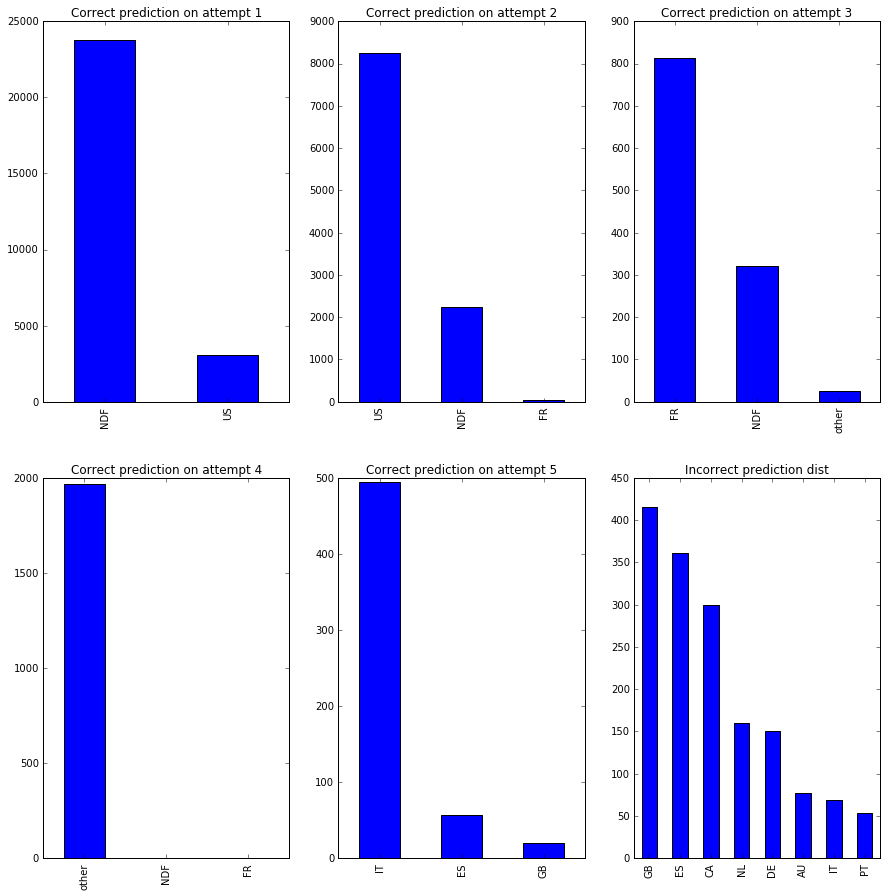

In [124]:
Dump(Predict_Top5(lr))

### Random Forest

In [125]:
# Train Random forest.
rf= RandomForestClassifier(n_estimators=10)
rf.fit(train_x, train_y)
rf_predictions = rf.predict(dev_x)
print "F1 score: {0}".format(metrics.f1_score(dev_y,rf_predictions,average="weighted"))

F1 score: 0.602285582797


In [126]:
# Predict Top 5 cities for each test example using Random forest model.
prob_est = rf.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], rf.classes_[index_of_score]))
output4 = pd.DataFrame(predictions, columns=["id", "country"])
version = 4
output4.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1137 with score of 0.82136.


final score: 0.81631

Correct prediction dist on attempt 1
NDF      22180
US        5163
FR          14
other       13
ES           1
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       5673
NDF      3322
FR         51
other      36
IT          2
CA          2
DE          1
NL          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
NDF      678
other    533
FR       409
US       252
IT        20
ES         6
GB         5
CA         3
AU         1
Name: country, dtype: int64

Correct prediction dist on attempt 4
other    1009
FR         85
NDF        47
US         29
GB         29
IT         29
ES         22
CA          9
DE          4
NL          2
AU          1
PT          1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       206
GB        76
other     65
FR        42
ES        29
CA        29
AU        10
NDF       10
DE         4
US         3
NL         2
Name: country, dtype: int64

Incorrect prediction dist
ES    

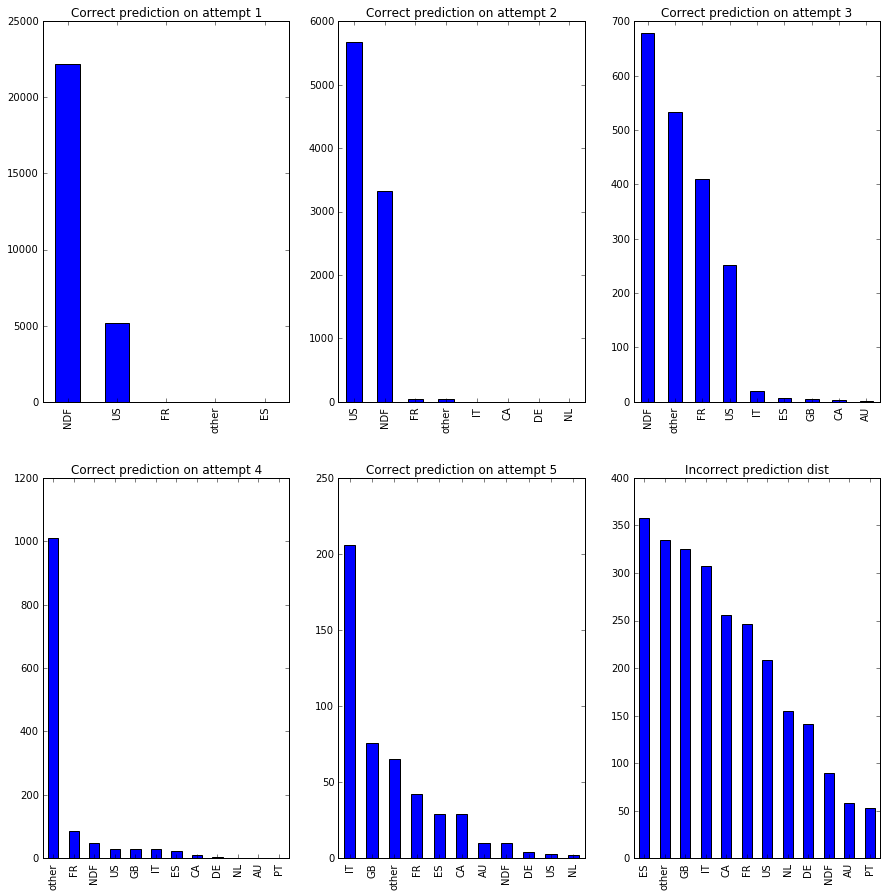

In [127]:
print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(rf)))
Dump(Predict_Top5(rf))

In [128]:
# Try voting ensemble
vc = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc.fit(train_x, train_y)

# Predict Top 5 cities for each test example using Random forest model.
prob_est = vc.predict_proba(test_data_x)
predictions = []
for i, example in enumerate(prob_est):
    sorted_scores = np.sort(example)
    top_5 = sorted_scores[len(sorted_scores) - 5:]
    for score in reversed(top_5):
        index_of_score = example.tolist().index(score)
        predictions.append((test_data["id"][i], vc.classes_[index_of_score]))
output = pd.DataFrame(predictions, columns=["id", "country"])
version = 7
output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)
# Ranks 1032 with score of 0.86252.

print "\nfinal score: %7.5f"%(FinalScore(Predict_Top5(vc)))


final score: 0.83037



Correct prediction dist on attempt 1
NDF      22648
US        5047
other        4
FR           3
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       6214
NDF      3534
FR         10
other       8
ES          1
IT          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
FR       708
other    292
NDF      152
US        75
IT         5
CA         3
NL         1
DE         1
Name: country, dtype: int64

Correct prediction dist on attempt 4
other    1556
FR        121
NDF        17
IT         16
GB          8
US          7
ES          3
DE          2
CA          2
AU          1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       300
other    102
GB        76
ES        64
CA        12
FR         6
NL         4
DE         2
PT         1
Name: country, dtype: int64

Incorrect prediction dist
GB       351
ES       350
CA       283
IT       242
NL       155
DE       145
AU        76
PT        53
other     29
Name: country, dtype:

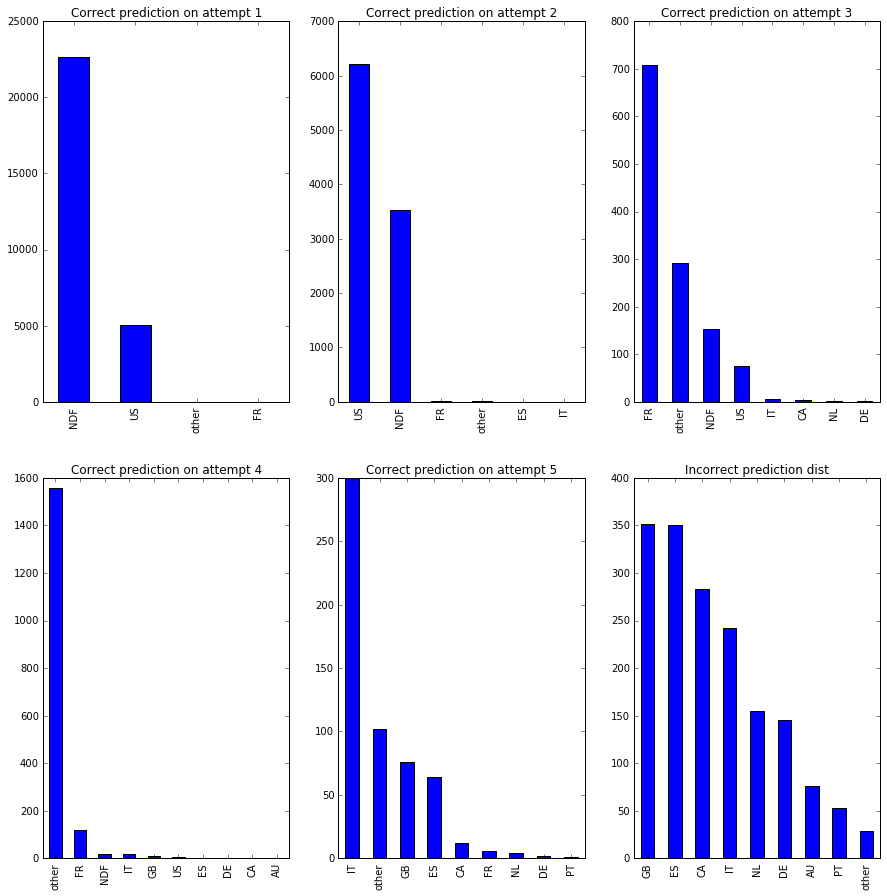

In [129]:
Dump(Predict_Top5(vc))

### Log of Improvements
1. Multinomial NB  
Baseline score: 0.63168  
Baseline rank: 1304  
2. Multinomial NB with Top 5 predictions  
Score: 0.79584  
Rank: 1142
3. Logistic Regression with Top 5 predictions  
Score: 0.85894  
Rank: 1049
4. Random Forest with Top 5 predictions  
Score: 0.81781  
Rank: 1138  
5. Logistic Regression with Age data clean-up  
Score improvement: 0.85970  
Rank improvement: 1044  
6. Soft voting with Logistic Regression and Random Forest   
Score improvement: 0.86252  
Rank improvement: 1032  
